<a href="https://colab.research.google.com/github/chsureshdaniel/Systems_bio_project/blob/main/Project_sys_bio_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
!pip install gitpython
from git import Repo
!git clone https://github.com/chsureshdaniel/Systems_bio_project.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Systems_bio_project' already exists and is not an empty directory.


In [ ]:
image_paths=[]
segmentation_paths=[]
for k in range(39):
    image_paths.append(("Systems_bio_project/block")+str(k+1)+(".tif"))
    
    segmentation_paths.append(("Systems_bio_project/output")+str(k+1)+(".png"))


In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_paths, segmentation_paths, transform=None):
        self.image_paths = image_paths
        self.segmentation_paths = segmentation_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        segmentation = Image.open(self.segmentation_paths[idx])
        
        if self.transform is not None:
            image = self.transform(image)
            segmentation = self.transform(segmentation)

        return image, segmentation


In [ ]:
from torchvision import transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    
    transforms.ToTensor(),
    
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

from sklearn.model_selection import train_test_split
num_workers=0
# Assuming you have lists of image and segmentation file pathsz
# image_paths = [...]  # List of image file paths
# segmentation_paths = [...]  # List of segmentation file paths

# Split the dataset into train and validation sets
train_image_paths, val_image_paths, train_segmentation_paths, val_segmentation_paths = train_test_split(
    image_paths, segmentation_paths, test_size=0.2, random_state=42)

# Create the train and validation datasets
train_dataset = CustomDataset(train_image_paths, train_segmentation_paths, transform=train_transform)
val_dataset = CustomDataset(val_image_paths, val_segmentation_paths, transform=val_transform)

print(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

In [ ]:
def dilate(img,window):
    m,n=img.shape
    r_1=np.zeros((m,n))
    def func(i,j):
        if i<0 or i>=m or j<0 or j>=n:
            return 0
        else:
            return int(img[i][j])
    for i in range(m):
        for j in range(n):
            for r,c in window:
                r_1[i][j]=int(r_1[i][j])|func(i+r,j+c)
#                 r_1[i][j]=func(i,j-1)|func(i-1,j)|func(i,j)|func(i,j+1)|func(i+1,j)
    return r_1
window=[[-1,0],[0,0],[1,0],[0,1],[0,-1],[1,1],[-1,-1],[-1,1],[1,-1]]

In [ ]:
import torch
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        # Upsample path
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Downsample path
        x1 = self.down1(x)
        
        x2 = self.down2(x1)
       
        x3 = self.down3(x2)
        
        x4 = self.down4(x3)
       

        # Upsample path
        x = self.up1(x4)
        
        x = torch.cat([x, x3], dim=1)
       
        x = self.up2(x)
        
        x = torch.cat([x, x2], dim=1)
        
        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up4(x)
        return x1,x2,x3,x4,x

    

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Create an instance of the UNet model

In [ ]:
# Define loss function and optimizer
import torch
from PIL import Image
import torch.nn.functional as F
torch.cuda.empty_cache()
in_channels=1
out_channels=1
losses = []
val_losses = []
# Create an instance of the UNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1,1).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs=100
# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images=np.array(images)
        labels=np.array(labels)
        
        
        optimizer.zero_grad()
        images=torch.tensor(images)
        labels=torch.tensor(labels)
        images=images.float()
        images=images.to(device)
        # Forward pass
        x1,x2,x3,x4,output = model(images)
        output=output.to('cpu')
        output = torch.sigmoid(output)
        # Compute loss
        
        loss = loss_fn(output, labels)
        losses.append(loss.item())
        

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for images_val, labels_val in val_loader:
            images_val=images_val.to(device)
            x1,x2,x3,x4,output_val = model(images_val)
            output_val = output_val.to('cpu')
            output_val = torch.sigmoid(output_val)
            val_loss = loss_fn(output_val, labels_val)
            val_losses.append(val_loss.item())
    if val_loss<0.01:
      break

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Save trained model
torch.save(model.state_dict(), 'unet_weights.pth')


Epoch 1/100, Loss: 0.0768, Val Loss: 0.0805
Epoch 2/100, Loss: 0.0041, Val Loss: 0.0396
Epoch 3/100, Loss: 0.0019, Val Loss: 0.0276
Epoch 4/100, Loss: 0.0173, Val Loss: 0.0201
Epoch 5/100, Loss: 0.0135, Val Loss: 0.0159
Epoch 6/100, Loss: 0.0014, Val Loss: 0.0164
Epoch 7/100, Loss: 0.0184, Val Loss: 0.0129
Epoch 8/100, Loss: 0.0119, Val Loss: 0.0139
Epoch 9/100, Loss: 0.0087, Val Loss: 0.0134
Epoch 10/100, Loss: 0.0152, Val Loss: 0.0151
Epoch 11/100, Loss: 0.0019, Val Loss: 0.0194


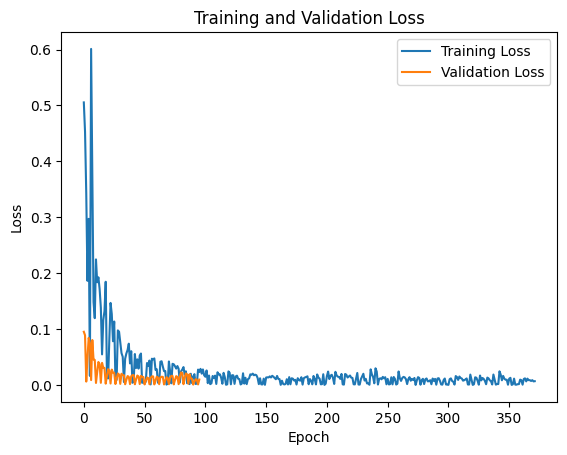

In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

F1 Score: 0.9686744658222952
Precision Value : 0.9760350706283487
Recall value : 0.9614240475961999
Confusion Matrix:
[[251477    246]
 [   402  10019]]


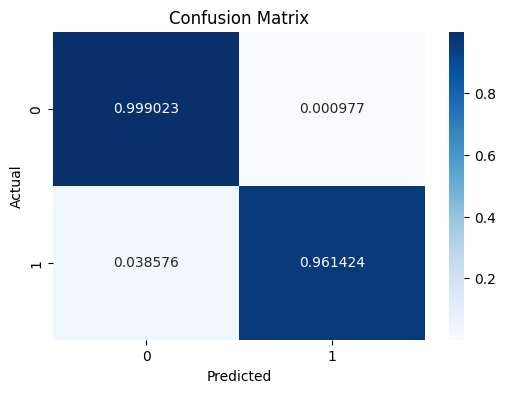

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
# Convert output and labels to binary values
output_binary = np.round(output.detach().numpy())
labels_binary = labels.detach().numpy()

# Calculate F1 score
f1 = f1_score(labels_binary.flatten(), output_binary.flatten())

# Generate confusion matrix
confusion_mat = confusion_matrix(labels_binary.flatten(), output_binary.flatten())

# Calculate precision and recall
precision = precision_score(labels_binary.flatten(), output_binary.flatten())
recall = recall_score(labels_binary.flatten(), output_binary.flatten())

print('F1 Score:', f1)
print('Precision Value :', precision)
print('Recall value :', recall)
print('Confusion Matrix:')
print(confusion_mat)

norm_conf = np.zeros((2, 2), dtype=float)
norm_conf[0][0] = confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[0][1])
norm_conf[0][1] = 1-norm_conf[0][0]
norm_conf[1][1] = confusion_mat[1][1]/(confusion_mat[1][0]+confusion_mat[1][1])
norm_conf[1][0] = 1-norm_conf[1][1]

plt.figure(figsize=(6, 4))
sns.heatmap(norm_conf, annot=True, fmt='f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Train Images - Input and Labels

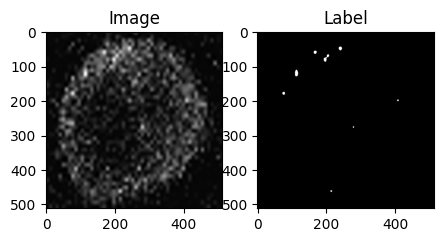

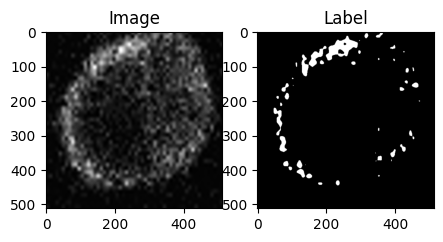

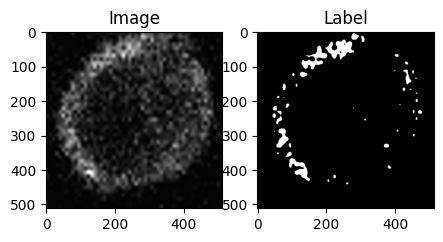

In [ ]:
#Train Images
selected_indices = [30, 5, 8]  # Specify the indices of the desired images
selected_images = []
selected_labels = []

# Loop through the train_loader and select images with the specified indices
for index, (images, labels) in enumerate(train_loader):
    if index in selected_indices:
        selected_images.append(images)
        selected_labels.append(labels)

# Process the selected images and labels
for images, labels in zip(selected_images, selected_labels):
    images = images[0, 0].numpy()  # Assuming the images are grayscale and have shape [1, 1, 512, 512]
    labels = labels[0, 0].numpy()  # Assuming the labels are grayscale and have shape [1, 1, 512, 512]
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(images, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(labels, cmap='gray')
    axes[1].set_title('Label')
    plt.show()


In [ ]:
# Load the pre-trained weights if available
def test(i4):
    model.load_state_dict(torch.load('unet_weights.pth'))

    # Set the model to evaluation mode
    model.eval()

    # Load and preprocess your input image

    # Convert the input image to a tensor
    input_tensor = i4
    input_tensor=i4.to(device)
    
    # Pass the input tensor through the model
    with torch.no_grad():
        x1,x2,x3,x4,output_val = model(input_tensor)
        
        output_val = output_val.to('cpu')
        
    tensor=output_val
    probs= (tensor - tensor.min()) / (tensor.max() - tensor.min())

    
    probs=probs.detach().numpy()
    
    # # Convert the predicted labels to a numpy array
    
    probs=probs.reshape((512,512))
    out=np.zeros(probs.shape)
    for i in range(512):
      for j in range(512):
        if probs[i][j]<0.6:
          out[i][j]=1

    out=np.array(out)
    out=dilate(out,window)
    out=1-out
    return x1,x2,x3,x4,out
    # plt.imshow(out,cmap='gray')


In [ ]:
def test1(i4):
    model.load_state_dict(torch.load('unet_weights.pth'))

    # Set the model to evaluation mode
    model.eval()

    # Load and preprocess your input image

    # Convert the input image to a tensor
    input_tensor = i4
    input_tensor=i4.to(device)
    # input_tensor=input_tensor.unsqueeze(0)
    # Pass the input tensor through the model
    with torch.no_grad():
        x1,x2,x3,x4,output_val = model(input_tensor)
        
        output_val = output_val.to('cpu')
        
    tensor=output_val
    probs= (tensor - tensor.min()) / (tensor.max() - tensor.min())

    
    probs=probs.detach().numpy()
   

    # # Convert the predicted labels to a numpy array
    
    probs=probs.reshape((512,512))
    out=np.zeros(probs.shape)
    for i in range(512):
      for j in range(512):
        if probs[i][j]<0.7:
          out[i][j]=1

    out=np.array(out)
    out=dilate(out,window)
    out=1-out
    return x1,x2,x3,x4,out
    # plt.imshow(out,cmap='gray')

Train Images - Input and Predicted Output images

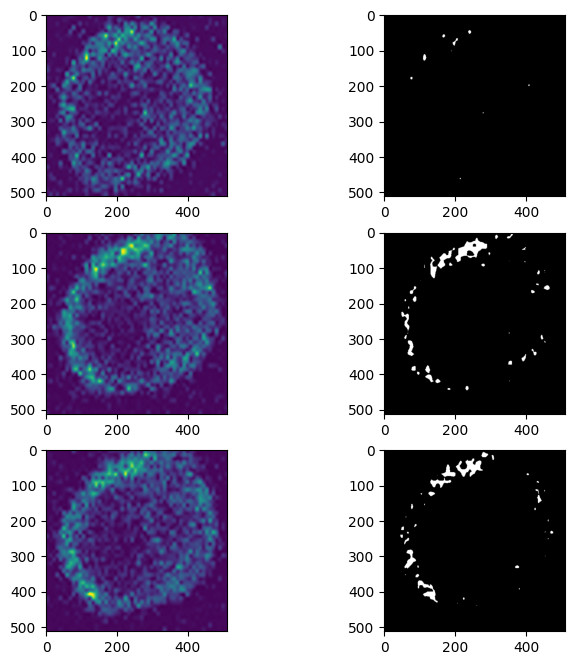

In [ ]:
n=len(selected_images)
rows=n
cols=2
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
for i in range(n):
  s=selected_images[i]
  t=selected_images[i]
  t=t.squeeze(0)
  t=t.squeeze(0)
  axes[i,0].imshow(t)
  x1,x2,x3,x4,out=test(s)
  # print(out.shape)
  axes[i,1].imshow(out,cmap='gray')

Test Images - Input and labels

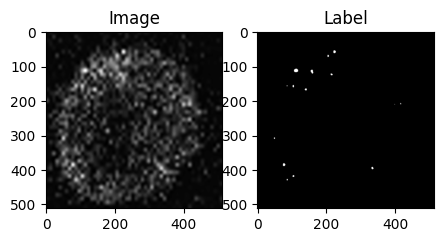

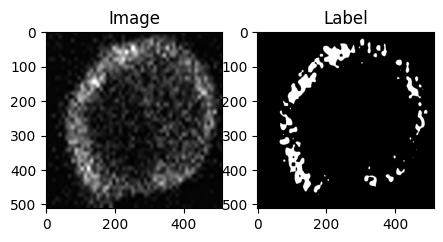

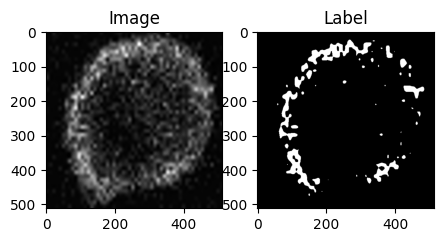

In [ ]:
#Test Images-  Input and labels
selected_indices = [2, 4, 7]  # Specify the indices of the desired images
selected_images = []
selected_labels = []

# Loop through the train_loader and select images with the specified indices
for index, (images, labels) in enumerate(val_loader):
    if index in selected_indices:
        selected_images.append(images)
        selected_labels.append(labels)

# Process the selected images and labels
for images, labels in zip(selected_images, selected_labels):
    images = images[0, 0].numpy()  # Assuming the images are grayscale and have shape [1, 1, 512, 512]
    labels = labels[0, 0].numpy()  # Assuming the labels are grayscale and have shape [1, 1, 512, 512]
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    axes[0].imshow(images, cmap='gray')
    axes[0].set_title('Image')
    axes[1].imshow(labels, cmap='gray')
    axes[1].set_title('Label')
    plt.show()


Test Images - Input and Predicted Output Images

(512, 512)
(512, 512)
(512, 512)


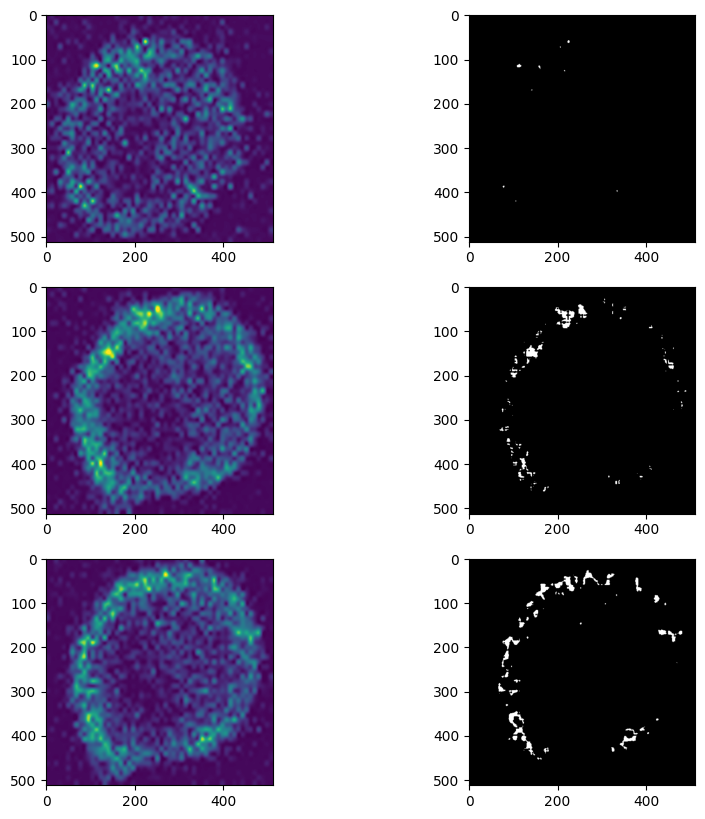

In [ ]:
#Test Images - Input 
n=len(selected_images)
rows=n
cols=2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(n):
  s=selected_images[i]
  t=selected_images[i]
  t=t.squeeze(0)
  t=t.squeeze(0)
  axes[i,0].imshow(t)
  x1,x2,x3,x4,out=test1(s)
  print(out.shape)
  axes[i,1].imshow(out,cmap='gray')

New Image

Text(0.5, 1.0, 'New Image')

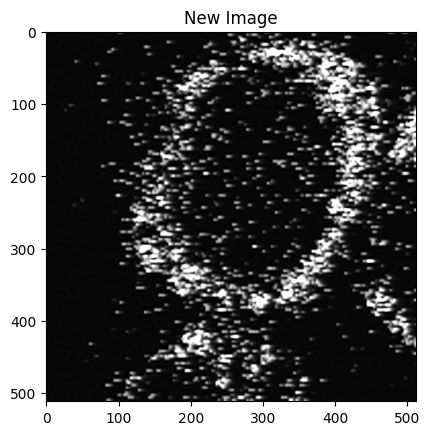

In [ ]:
input_img = Image.open('/content/Systems_bio_project/new_pca.tif')
input_array = np.array(input_img)
#input_img_resize = resize(input_array,(512,512))
# tensor_img = input_array.to(device)
# tensor_img = tensor_img.unsqueeze(0)
input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
plt.imshow(input_img, cmap='gray')
plt.title("New Image")

In [ ]:
def trans(x,k=0):
  x_1=x.squeeze(0)
  x_1=x_1[k,:,:]
  x_1=x_1.to('cpu')
  return x_1




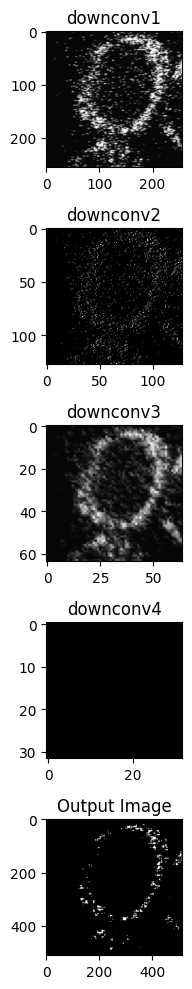

In [ ]:
model.load_state_dict(torch.load('unet_weights.pth'))
rows=5
cols=1
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
model.eval()
with torch.no_grad():
  x1,x2,x3,x4,output_val = model(input_tensor)
  output_val = output_val.to('cpu')
  tensor = output_val
  probs = (tensor-tensor.min())/(tensor.max()-tensor.min())
  probs = probs.detach().numpy()
  probs = probs.reshape((512,512))
  out = np.zeros(probs.shape)
  for i in range(512):
    for j in range(512):
      if probs[i][j]<0.5:
        out[i][j] = 1
  out = np.array(out)
  out = dilate(out, window)
  out = 1-out

# print(x1.shape)
# x_1=x1.squeeze(0)
# # x_1=x_1[0,:,:]
# print(x_1.shape)

# print(x_1.shape)

axes[0].set_title('downconv1')
axes[0].imshow(trans(x1,10),cmap='gray')
axes[1].set_title('downconv2')
axes[1].imshow(trans(x2,15),cmap='gray')
axes[2].set_title('downconv3')
axes[2].imshow(trans(x3,10),cmap='gray')
axes[3].set_title('downconv4')
axes[3].imshow(trans(x4,10),cmap='gray')
axes[4].set_title('Output Image')
axes[4].imshow(out,cmap='gray')
plt.tight_layout()

  # plt.imshow(out, cmap='gray')
  # plt.title('Predicted New image')